In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 16.0 MB/s eta 0:00:00


In [7]:
import numpy as np
import gymnasium as gym
import random
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

import os
from google.colab import files

# DQN

Задаем структуру аппроксимации $Q^\theta$, начальные вектор параметров $\theta$, вероятность исследования среды $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

- Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$, где $\pi = \varepsilon\text{-greedy}(Q^\theta)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$. Сохраняем $(S_t,A_t,R_t,S_{t+1}) \rightarrow Memory$


- Берем $\{(s_i,a_i,r_i,s'_i)\}_{i=1}^{n} \leftarrow Memory$, определяем целевые значения

$$
y_i =
\left\{
\begin{array}{ll}
r_i, &\text{ если } s'_i\text{ -терминальное},\\[0.0cm]
 r_i + \gamma \max\limits_{a'} Q^\theta(s'_i,a'), &\text{ иначе}
\end{array}
\right.
$$

функцию потерь $Loss(\theta) = \frac{1}{n}\sum\limits_{i=1}^n \big(y_i - Q^\theta(s_i,a_i)\big)^2$
и обновляем вектор параметров

$$
\theta \leftarrow \theta - \alpha \nabla_\theta Loss(\theta)
$$

- Уменьшаем $\varepsilon$


In [27]:
class Network(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64, dropout_prob=0.0):
        super().__init__()

        self.linear_1 = nn.Linear(input_dim, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, hidden_size)
        self.linear_3 = nn.Linear(hidden_size, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.activation = nn.ReLU()

    def forward(self, input):
        hidden = self.linear_1(input)
        hidden = self.dropout(hidden)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.dropout(hidden)
        hidden = self.activation(hidden)
        output = self.linear_3(hidden)
        return output

In [28]:
class DQN:
    def __init__(self, state_dim, action_n, epsilon_decrease, hidden_size, dropout, gamma=0.99, batch_size=128, lr=1e-3, epsilon_min=1e-2):
        self.state_dim = state_dim
        self.action_n = action_n
        self.q_model = Network(self.state_dim, self.action_n, hidden_size=hidden_size, dropout_prob=dropout)
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.epsilon = 1
        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = []
        self.optimizer = torch.optim.Adam(self.q_model.parameters(), lr=lr)

    def get_action(self, state):
        q_values = self.q_model(torch.FloatTensor(state)).data.numpy()
        max_action = np.argmax(q_values)
        probs = np.ones(self.action_n) * self.epsilon / self.action_n
        probs[max_action] += 1 - self.epsilon
        return np.random.choice(np.arange(self.action_n), p=probs)

    def fit(self, state, action, reward, done, next_state):
        self.memory.append([state, action, reward, int(done), next_state])

        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, zip(*batch))

            targets = rewards + (1 - dones) * self.gamma * torch.max(self.q_model(next_states), dim=1).values
            q_values = self.q_model(states)[torch.arange(self.batch_size), actions]
            loss = torch.mean((q_values - targets) ** 2)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

            self.epsilon = max(self.epsilon - self.epsilon_decrease, self.epsilon_min)

trajectory: 0, total_reward -500.0
trajectory: 1, total_reward -500.0
trajectory: 2, total_reward -500.0
trajectory: 3, total_reward -500.0
trajectory: 4, total_reward -500.0
trajectory: 5, total_reward -500.0
trajectory: 6, total_reward -500.0
trajectory: 7, total_reward -500.0
trajectory: 8, total_reward -500.0
trajectory: 9, total_reward -500.0
trajectory: 10, total_reward -500.0
trajectory: 11, total_reward -500.0
trajectory: 12, total_reward -500.0
trajectory: 13, total_reward -500.0
trajectory: 14, total_reward -500.0
trajectory: 15, total_reward -500.0
trajectory: 16, total_reward -500.0
trajectory: 17, total_reward -500.0
trajectory: 18, total_reward -500.0
trajectory: 19, total_reward -500.0
trajectory: 20, total_reward -500.0
trajectory: 21, total_reward -500.0
trajectory: 22, total_reward -500.0
trajectory: 23, total_reward -500.0
trajectory: 24, total_reward -500.0
trajectory: 25, total_reward -500.0
trajectory: 26, total_reward -500.0
trajectory: 27, total_reward -453.0
tr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

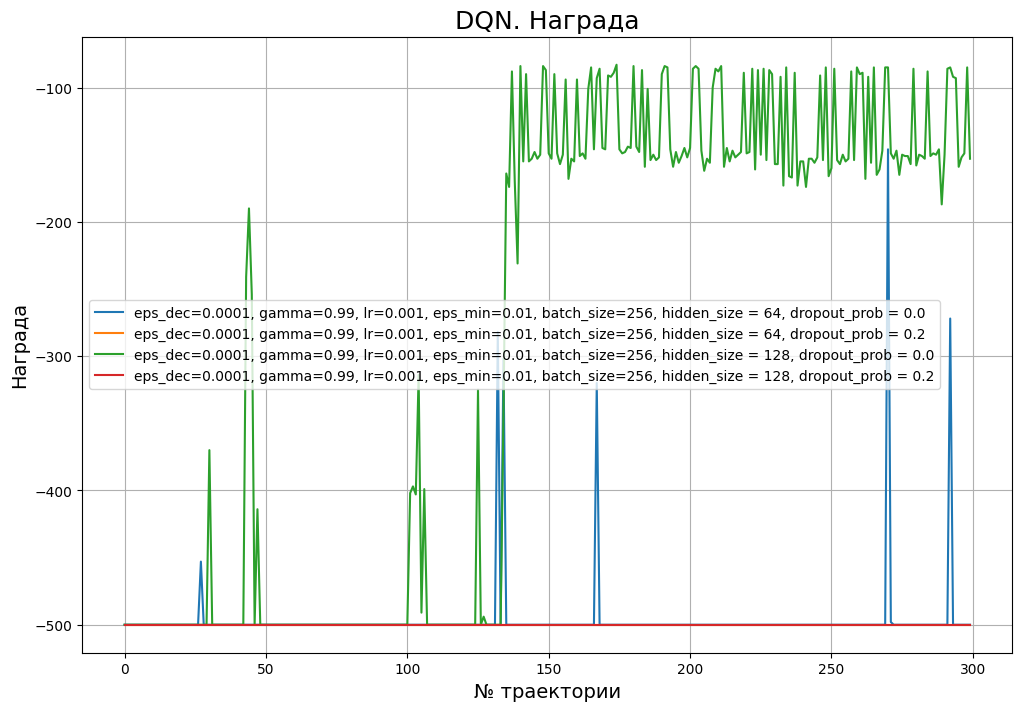

In [31]:
epsilons_decrease = [1e-4]
#epsilons_decrease = [1e-4]
#gammas = [0.5, 0.7, 0.9, 0.99]
gammas = [0.99]
batch_sizes = [256]
#batch_sizes = [128]
#lrs = [1e-3, 1e-2, 1e-1]
lrs = [1e-3]
epsilons_min = [1e-2]
#epsilons_min = [1e-2]
trajectorys_n = [300]
#trajectorys_n = [300]
#trajectorys_len = [300, 500, 1000]
trajectorys_len = [500]

hidden_sizes = [64, 128]
dropouts = [0.0, 0.2]

plt.figure(figsize=(12, 8))

for hidden_size in hidden_sizes:
  for dropout in dropouts:
    for epsilon_decrease in epsilons_decrease:
      for gamma in gammas:
        for batch_size in batch_sizes:
          for lr in lrs:
            for epsilon_min in epsilons_min:
              for trajectory_n in trajectorys_n:
                for trajectory_len in trajectorys_len:
                  env = gym.make('MountainCar-v0')
                  state_dim = env.observation_space.shape[0]
                  action_n = env.action_space.n

                  agent = DQN(state_dim, action_n, epsilon_decrease=epsilon_decrease, batch_size=batch_size, lr=lr, epsilon_min=epsilon_min, gamma=gamma, hidden_size=hidden_size, dropout=dropout)

                  trajectory_n = trajectory_n
                  trajectory_len = trajectory_len

                  rewards = []

                  for trajectory in range(trajectory_n):
                      total_reward = 0
                      state, _ = env.reset()
                      for t in range(trajectory_len):
                          action = agent.get_action(state)
                          next_state, reward, done, _, _ = env.step(action)
                          total_reward += reward

                          agent.fit(state, action, reward, done, next_state)

                          state = next_state

                          if done:
                              break

                      rewards.append(total_reward)
                      print(f'trajectory: {trajectory}, total_reward {total_reward}')

                  sns.lineplot(
                      x=range(len(rewards)),
                      y=rewards,
                      label=f"eps_dec={epsilon_decrease}, gamma={gamma}, lr={lr}, eps_min={epsilon_min}, batch_size={batch_size}, hidden_size = {hidden_size}, dropout_prob = {dropout}"
                  )

plt.title("DQN. Награда", fontsize=18)
plt.xlabel("№ траектории", fontsize=14)
plt.ylabel("Награда", fontsize=14)
plt.legend()
plt.grid(True)

save_path = "/content"
filename = "graph.png"
plt.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches='tight')
files.download(os.path.join(save_path, filename))

plt.show()

In [42]:
def discretize_state(state, levels):
    if isinstance(state, (np.ndarray, list, tuple)):
        state_array = np.array(state, dtype=np.float32).flatten()
        return np.round(state_array * levels) / levels
    else:
        return round(state * levels) / levels

class DCEM(nn.Module):
    def __init__(self, state_dim, action_n, epsilon=0, epsilon_decrease=1e-3, epsilon_min=1e-2, hidden_size=128, lr=1e-2):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.network = nn.Sequential(
            nn.Linear(self.state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.action_n)
        )
        self.softmax = nn.Softmax(dim=-1)
        self.optimazer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.CrossEntropyLoss()
        self.epsilon = epsilon
        self.epsilon_descrease = epsilon_decrease
        self.epsilon_min = epsilon_min

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        probs = (1 - self.epsilon) * self.softmax(logits) + self.epsilon / self.action_n
        action_distribution = torch.distributions.Categorical(probs)
        action = action_distribution.sample().item()
        return action

    def fit(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                elite_states.append(state)
                elite_actions.append(action)

        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        pred_actions = self.forward(elite_states)

        loss = self.loss(pred_actions, elite_actions)
        loss.backward()
        self.optimazer.step()
        self.optimazer.zero_grad()

        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_descrease)

def get_trajectory(env, agent, max_len=1000):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    state, info = env.reset()

    for _ in range(max_len):
        state = discretize_state(state, 10)
        trajectory['states'].append(state)

        action = agent.get_action(state)
        trajectory['actions'].append(action)

        next_state, reward, terminated, truncated, info = env.step(action)
        trajectory['rewards'].append(reward)

        if terminated or truncated:
            break

        state = next_state

    return trajectory

def DCEM_fit_agent(env, state_dim, action_n, iteration_n, epsilon, hidden_size, lr, trajectory_n, trajectory_len, q):
    agent = DCEM(state_dim, action_n, epsilon_decrease=1/iteration_n, epsilon=epsilon, hidden_size=hidden_size, lr=lr)
    mean_total_rewards = []
    for iteration in range(iteration_n):
        # Policy evaluation
        trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
        total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
        print('Iteration:', iteration, 'Mean total reward:', np.mean(total_rewards))

        mean_total_rewards.extend([np.mean(total_rewards)] * trajectory_n)

        # Policy improvement
        quantile = np.quantile(total_rewards, q)
        elite_trajectories = []
        for trajectory in trajectories:
            total_reward = np.sum(trajectory['rewards'])
            if total_reward > quantile:
                elite_trajectories.append(trajectory)

        if len(elite_trajectories) > 0:
            agent.fit(elite_trajectories)

    trajectory = get_trajectory(env, agent, max_len=trajectory_len)
    return mean_total_rewards

In [ ]:
env = gym.make('MountainCar-v0')
state_dim = env.observation_space.shape[0]
action_n = env.action_space.n
DeepCrossEntropy_total_rewards = DCEM_fit_agent(env=env, state_dim=state_dim, action_n=action_n, iteration_n=100, epsilon=0.3,
                                                hidden_size=128, lr=1e-2, trajectory_n=300, trajectory_len=500, q=0.8)

Iteration: 0 Mean total reward: -200.0
Iteration: 1 Mean total reward: -200.0
Iteration: 2 Mean total reward: -200.0
Iteration: 3 Mean total reward: -200.0
Iteration: 4 Mean total reward: -200.0
Iteration: 5 Mean total reward: -200.0
Iteration: 6 Mean total reward: -200.0
Iteration: 7 Mean total reward: -200.0
Iteration: 8 Mean total reward: -200.0
Iteration: 9 Mean total reward: -200.0
Iteration: 10 Mean total reward: -200.0
Iteration: 11 Mean total reward: -200.0
Iteration: 12 Mean total reward: -200.0
Iteration: 13 Mean total reward: -200.0
Iteration: 14 Mean total reward: -200.0
Iteration: 15 Mean total reward: -200.0
Iteration: 16 Mean total reward: -200.0
Iteration: 17 Mean total reward: -200.0
Iteration: 18 Mean total reward: -200.0
Iteration: 19 Mean total reward: -200.0
Iteration: 20 Mean total reward: -200.0
Iteration: 21 Mean total reward: -200.0
Iteration: 22 Mean total reward: -200.0
Iteration: 23 Mean total reward: -200.0
Iteration: 24 Mean total reward: -200.0
Iteration:

In [ ]:
epsilons_decrease = [1e-4]
#epsilons_decrease = [1e-4]
#gammas = [0.5, 0.7, 0.9, 0.99]
gammas = [0.99]
batch_sizes = [1024]
#batch_sizes = [128]
#lrs = [1e-3, 1e-2, 1e-1]
lrs = [1e-3]
epsilons_min = [1e-2]
#epsilons_min = [1e-2]
trajectorys_n = [300]
#trajectorys_n = [300]
#trajectorys_len = [300, 500, 1000]
trajectorys_len = [500]

hidden_sizes = [128]
dropouts = [0.0]

plt.figure(figsize=(12, 8))

sns.lineplot(
    x=range(len(DeepCrossEntropy_total_rewards)),
    y=DeepCrossEntropy_total_rewards,
    label=f"CEM"
)

for hidden_size in hidden_sizes:
  for dropout in dropouts:
    for epsilon_decrease in epsilons_decrease:
      for gamma in gammas:
        for batch_size in batch_sizes:
          for lr in lrs:
            for epsilon_min in epsilons_min:
              for trajectory_n in trajectorys_n:
                for trajectory_len in trajectorys_len:
                  env = gym.make('MountainCar-v0')
                  state_dim = env.observation_space.shape[0]
                  action_n = env.action_space.n

                  agent = DQN(state_dim, action_n, epsilon_decrease=epsilon_decrease, batch_size=batch_size, lr=lr, epsilon_min=epsilon_min, gamma=gamma, hidden_size=hidden_size, dropout=dropout)

                  trajectory_n = trajectory_n
                  trajectory_len = trajectory_len

                  rewards = []

                  for trajectory in range(trajectory_n):
                      total_reward = 0
                      state, _ = env.reset()
                      for t in range(trajectory_len):
                          action = agent.get_action(state)
                          next_state, reward, done, _, _ = env.step(action)
                          total_reward += reward

                          agent.fit(state, action, reward, done, next_state)

                          state = next_state

                          if done:
                              break

                      rewards.append(total_reward)
                      print(f'trajectory: {trajectory}, total_reward {total_reward}')

                  sns.lineplot(
                      x=range(len(rewards)),
                      y=rewards,
                      label=f"eps_dec={epsilon_decrease}, gamma={gamma}, lr={lr}, eps_min={epsilon_min}, batch_size={batch_size}, hidden_size = {hidden_size}, dropout_prob = {dropout}"
                  )

plt.title("DQN. Награда", fontsize=18)
plt.xlabel("№ траектории", fontsize=14)
plt.ylabel("Награда", fontsize=14)
plt.legend()
plt.grid(True)

save_path = "/content"
filename = "graph.png"
plt.savefig(os.path.join(save_path, filename), dpi=300, bbox_inches='tight')
files.download(os.path.join(save_path, filename))

plt.show()